[A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)

Code here follows the [TensorFlow](https://www.tensorflow.org/) implementation by Mark Chang found [here](https://github.com/ckmarkoh/neuralart_tensorflow).

In [2]:
from __future__ import print_function
import tensorflow as tf
import numpy as np
import scipy.io
import scipy.misc
from skimage.transform import resize
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from tensorflow.python.framework import ops

In [4]:
vggmodelfile = 'imagenet-vgg-verydeep-19.mat'
if not os.path.isfile(os.path.join('.', vggmodelfile)):
    import six.moves.urllib.request as request
    # use `dl=1` as part of query to force a download
    origin = ('https://www.dropbox.com/s/qy9gikdpuq95w8n/%s?dl=1' % vggmodelfile)
    print('Downloading VGG16 model from: %s' % origin)
    request.urlretrieve(origin, vggmodelfile)

In [5]:
image_dir = './images'
source_image = 'MALcloudGate2560x1600.jpg'
style_image = 'impressionist.jpg'

source = os.path.join(image_dir, source_image)
style = os.path.join(image_dir, style_image)

if os.path.isdir(image_dir):
    print('Image directory is ready...')
else:
    os.makedirs(image_dir)
        
if os.path.exists(source):
    print('Source image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/9cosz20ijl4xerm/%s?dl=1' % source_image)
    print('Downloading source image from: %s' % origin)
    request.urlretrieve(origin, source)

if os.path.exists(style):
    print('Style image exists...')
else:
    import six.moves.urllib.request as request
    origin = ('https://www.dropbox.com/s/8frdjcgf7vnjosx/%s?dl=1' % style_image)
    print('Downloading style image from: %s' % origin)
    request.urlretrieve(origin, style)

Image directory is ready...
Source image exists...
Style image exists...


In [6]:
def imshow_clean(img, interpolation=None):
    fig = plt.figure()
    ax = plt.gca()
    ax.axis('off')
    im = ax.imshow(img, interpolation=interpolation)
    return im

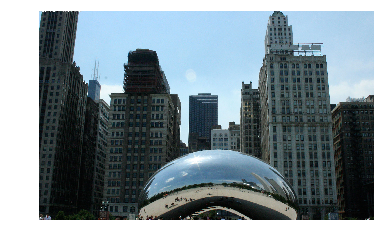

In [7]:
source_data = plt.imread(source)
imshow_clean(source_data)

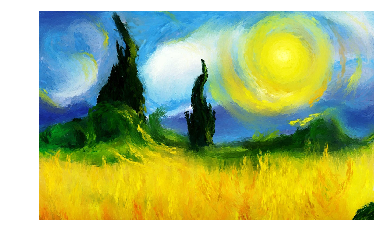

In [8]:
style_data = plt.imread(style)
imshow_clean(style_data)

In [9]:
print(source_data.shape)
print(style_data.shape)

(1600, 2560, 3)
(1200, 1920, 3)


In TensorFlow, image tensor shapes should be : `N x H x W x NChannels`. We will be using a pre-trained VGG16 model here, so we need to resize our images appropriately.

In [10]:
IMAGE_W = 800   # 1.333 aspect ratio
IMAGE_H = 600

In [11]:
1600 * 1.333

2132.7999999999997

(1200, 1600, 3)


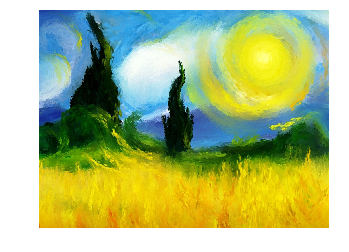

In [12]:
style_clipped = style_data[:,160:1760,:]   # 1200 * 1.333 ~ 1600, take center clip
print(style_clipped.shape)
imshow_clean(style_clipped)

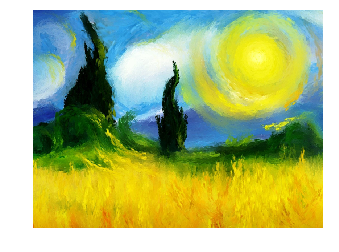

In [13]:
style_resized = resize(style_clipped, (IMAGE_H, IMAGE_W, 3))
imshow_clean(style_resized)

(1600, 2132, 3)


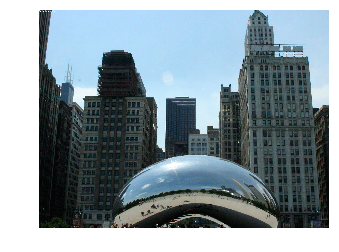

In [14]:
source_clipped = source_data[:,214:2346,:]    # 1600 * 1.333 ~ 2132, take center clip
print(source_clipped.shape)
imshow_clean(source_clipped)

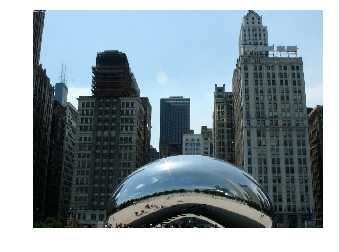

In [15]:
source_resized = resize(source_clipped, (IMAGE_H, IMAGE_W, 3))
imshow_clean(source_resized)

In [16]:
print(source_resized.shape)
print(style_resized.shape)

(600, 800, 3)
(600, 800, 3)


In [17]:
# rename for convenience / simplicity
source_img = source_resized
style_img = style_resized

In [18]:
# some global vars for training
INI_NOISE_RATIO = 0.7
STYLE_STRENGTH = 500
ITERATION = 100

In [19]:
CONTENT_LAYERS = [('conv4_2', 1.)]
STYLE_LAYERS = [('conv1_1', 1.), ('conv2_1', 1.), ('conv3_1', 1.), ('conv4_1', 1.), ('conv5_1', 1.)]

In [20]:
MEAN_VALUES = np.array([123, 117, 104]).reshape((1,1,1,3))

In [21]:
def build_net(ntype, nin, rwb=None):
    """
    utility function for building network layers
    * ntype == network layer type
    * nin == network input layer
    """
    # `strides` basically describe how far the kernel steps in each tensor dimension
    # `ksize` describes the size of the pooling region
    # If we use `SAME` padding, the filter is allowed to go off the edge by half the filter size on each side,
    # so we would expect an unchanged image size with stride=1 and a (1/2)x(1/2) for stride=2.
    if ntype == 'conv':
        return tf.nn.relu(tf.nn.conv2d(nin, rwb[0], strides=[1, 1, 1, 1], padding='SAME') + rwb[1])
    elif ntype == 'pool':
        return tf.nn.avg_pool(nin, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

Padding is explained in the TF [documentation for convolution](https://www.tensorflow.org/api_docs/python/nn/convolution#convolution). 

Let's demonstrate it with the pooling operation:

In [22]:
# X shape of None x 6 x 6 x 1 -> any number of 6x6 tensors that are "1-deep" (e.g., grayscale)
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

TensorFlow separates graph definition and computation into two steps - we must execute operations within a _Session_.

In [23]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

We need to pass a tensor with actual data into our "graph" to see how it works.

In [24]:
X_vals = np.arange(6*6).reshape(1, 6, 6, 1)
print(X_vals)

[[[[ 0]
   [ 1]
   [ 2]
   [ 3]
   [ 4]
   [ 5]]

  [[ 6]
   [ 7]
   [ 8]
   [ 9]
   [10]
   [11]]

  [[12]
   [13]
   [14]
   [15]
   [16]
   [17]]

  [[18]
   [19]
   [20]
   [21]
   [22]
   [23]]

  [[24]
   [25]
   [26]
   [27]
   [28]
   [29]]

  [[30]
   [31]
   [32]
   [33]
   [34]
   [35]]]]


In [25]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals)

[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [26]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals)

[[[[  3.5]
   [  5.5]
   [  7.5]]

  [[ 15.5]
   [ 17.5]
   [ 19.5]]

  [[ 27.5]
   [ 29.5]
   [ 31.5]]]]


In [27]:
ops.reset_default_graph()

<img src='./poolig_examp.png'>

In [28]:
X = tf.placeholder(tf.float32, shape=(None, 6, 6, 1), name='X')
Y_same = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='SAME')
Y_valid = tf.nn.avg_pool(X, ksize=[1, 2, 2, 1], strides=[1, 1, 1, 1], padding='VALID')

In [29]:
# we are using the default graph, so we have to re-initialize
sess = tf.Session()
sess.run(tf.initialize_all_variables())

In [30]:
Y_same_vals = sess.run(Y_same, feed_dict={X: X_vals})
print(Y_same_vals.shape)
print(Y_same_vals)

(1, 6, 6, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]
   [  8. ]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]
   [ 14. ]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]
   [ 20. ]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]
   [ 26. ]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]
   [ 32. ]]

  [[ 30.5]
   [ 31.5]
   [ 32.5]
   [ 33.5]
   [ 34.5]
   [ 35. ]]]]


In [31]:
Y_valid_vals = sess.run(Y_valid, feed_dict={X: X_vals})
print(Y_valid_vals.shape)
print(Y_valid_vals)

(1, 5, 5, 1)
[[[[  3.5]
   [  4.5]
   [  5.5]
   [  6.5]
   [  7.5]]

  [[  9.5]
   [ 10.5]
   [ 11.5]
   [ 12.5]
   [ 13.5]]

  [[ 15.5]
   [ 16.5]
   [ 17.5]
   [ 18.5]
   [ 19.5]]

  [[ 21.5]
   [ 22.5]
   [ 23.5]
   [ 24.5]
   [ 25.5]]

  [[ 27.5]
   [ 28.5]
   [ 29.5]
   [ 30.5]
   [ 31.5]]]]


In [32]:
ops.reset_default_graph()

In [33]:
def get_weight_bias(vgg_layers, i):
    """
    utility function to 'freeze' and return weights and bias values from the layers
    """
    weights = vgg_layers[i][0][0][0][0][0]
    weights = tf.constant(weights)
    bias = vgg_layers[i][0][0][0][0][1]
    bias = tf.constant(np.reshape(bias, (bias.size)))
    return weights, bias